In [86]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from enum import Enum


class ArrayPartitionTypes(Enum):
    complete = "complete"
    block = "block"
    cyclic = "cyclic"

@dataclass(frozen=True)
class ArrayPartition:
    variable: str
    dim: int
    type: ArrayPartitionTypes
    factor: int | None = None

@dataclass(frozen=True)
class MemoryOptimization:
    arrayPartition: ArrayPartition

class PipelineStyle(Enum):
    stp = "stp"
    flp = "flp"
    frp = "frp"

@dataclass(frozen=True)
class Pipeline:
    off: bool
    II: int | None = None
    rewind: bool | None = None
    style: PipelineStyle | None = None

@dataclass(frozen=True)
class Unroll:
    off: bool
    factor: int | None = None
    skip_exit_check: bool | None = None

@dataclass(frozen=True)
class Dataflow:
    pass


@dataclass(frozen=True)
class StructureOptimization:
    label: str
    pipeline: Pipeline | None = None
    unroll: Unroll | None = None
    dataflow: Dataflow | None = None


@dataclass(frozen=True)
class OptimizationStrategy:
    memory: list[MemoryOptimization]
    structure: list[StructureOptimization]

@dataclass(frozen=True)
class HLSReport:
    reportName: str
    latency_ns: int
    bram: int
    dsp: int
    ff: int
    lut: int
    uram: int
    taskSpecificInfo: dict[str, any]
    optimizations: OptimizationStrategy

def toDictRepresentation(report: HLSReport):
    result = {
        "ReportName": [report.reportName],
        "M": [report.taskSpecificInfo["M"]],
        "P": [report.taskSpecificInfo["P"]],
        "N": [report.taskSpecificInfo["N"]],
        "Latency_ns": [report.latency_ns],
        "BRAM": [report.bram],
        "DSP": [report.dsp],
        "FF": [report.ff],
        "LUT": [report.lut],
        "URAM": [report.uram],
    }

    variables: list[str] = []
    dim: list[int] = []
    type: list[ArrayPartitionTypes] = []
    factor: list[int | None] = []
    for m in report.optimizations.memory:
        variables.append(m.arrayPartition.variable)
        dim.append(m.arrayPartition.dim)
        type.append(m.arrayPartition.type.name)
        factor.append(m.arrayPartition.factor)

    memory = {
        "ReportName": [report.reportName for i in range(len(variables))],
        "Variables": variables,
        "Dim": dim,
        "Type": type,
        "Factor": factor
    }


    labels: list[str] = []
    optimizationTechniques: list[str] = []
    
    pipelineOff: list[bool | None] = []
    pipelineII: list[int | None] = []
    pipelineRewind: list[bool | None] = []
    pipelineStyle: list[str | None] = []

    unrollOff: list[bool | None] = []
    unrollFactor: list[int | None] = []
    unrollSkipExitCheck: list[bool | None] = []

    for s in report.optimizations.structure:
        labels.append(s.label)

        usedOptimizations: list[str] = []

        if s.dataflow != None:
            usedOptimizations.append("Dataflow")
        if s.pipeline != None:
            usedOptimizations.append("Pipeline")
            pipelineOff.append(s.pipeline.off)
            pipelineII.append(s.pipeline.II)
            pipelineRewind.append(s.pipeline.rewind)
            pipelineStyle.append(s.pipeline.style)
        else:
            pipelineOff.append(None)
            pipelineII.append(None)
            pipelineRewind.append(None)
            pipelineStyle.append(None)


        if s.unroll != None:
            usedOptimizations.append("Unroll")
            unrollOff.append(s.unroll.off)
            unrollFactor.append(s.unroll.factor)
            unrollSkipExitCheck.append(s.unroll.skip_exit_check)
        else:
            unrollOff.append(None)
            unrollFactor.append(None)
            unrollSkipExitCheck.append(None)

        optimizationTechniques.append(str(usedOptimizations))



    optimizations = {
        "ReportName": [report.reportName for i in range(len(labels))],
        "Label": labels,
        "Techniques": optimizationTechniques,
        "Pipeline - Off": pipelineOff,
        "Pipeline - II": pipelineII,
        "Pipeline - Style": pipelineStyle,
        "Pipeline - Rewind": pipelineRewind,
        "Unroll - Off": unrollOff,
        "Unroll - Factor": unrollFactor,
        "Unroll - SkipExitCheck": unrollSkipExitCheck,
    }


    return result, memory, optimizations

def concatDictRepresentation(result0: dict[str, list[any]], memory0: dict[str, list[any]], optimizations0: dict[str, list[any]], result1: dict[str, list[any]], memory1: dict[str, list[any]], optimizations1: dict[str, list[any]]):
    for key, value in result0.items():
        result0[key].extend(result1[key])

    for key, value in memory0.items():
        memory0[key].extend(memory1[key])
    
    for key, value in optimizations0.items():
        optimizations0[key].extend(optimizations1[key])

    return result0, memory0, optimizations0


In [87]:
reports: list[HLSReport] = []

reports.append(HLSReport(
    reportName="Optimization 0",
    latency_ns=2590,
    bram=0,
    dsp=16,
    ff=33,
    lut=366,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 1",
    latency_ns=10270,
    bram=0,
    dsp=32,
    ff=39,
    lut=599,
    uram=0,
    taskSpecificInfo={
        "M": 32,
        "P": 8,
        "N": 32
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 2",
    latency_ns=41000,
    bram=0,
    dsp=64,
    ff=105,
    lut=1040,
    uram=0,
    taskSpecificInfo={
        "M": 64,
        "P": 16,
        "N": 64
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 3",
    latency_ns=164000,
    bram=0,
    dsp=128,
    ff=2249,
    lut=1983,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "P": 32,
        "N": 128
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 4",
    latency_ns=65500,
    bram=0,
    dsp=256,
    ff=4306,
    lut=3709,
    uram=0,
    taskSpecificInfo={
        "M": 256,
        "P": 64,
        "N": 256
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 5",
    latency_ns=2621000,
    bram=0,
    dsp=512,
    ff=8410,
    lut=7201,
    uram=0,
    taskSpecificInfo={
        "M": 512,
        "P": 128,
        "N": 512
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 6",
    latency_ns=164000,
    bram=0,
    dsp=96,
    ff=147,
    lut=1453,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "P": 24,
        "N": 128
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 7",
    latency_ns=164000,
    bram=0,
    dsp=192,
    ff=3273,
    lut=2773,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "P": 48,
        "N": 128
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 8",
    latency_ns=164000,
    bram=0,
    dsp=384,
    ff=6345,
    lut=5311,
    uram=0,
    taskSpecificInfo={
        "M":128,
        "P": 96,
        "N": 128
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 9",
    latency_ns=164000,
    bram=0,
    dsp=768,
    ff=12489,
    lut=10373,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "P": 192,
        "N": 128
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 10",
    latency_ns=328000,
    bram=0,
    dsp=96,
    ff=153,
    lut=1440,
    uram=0,
    taskSpecificInfo={
        "M": 256,
        "P": 24,
        "N": 128
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 11",
    latency_ns=328000,
    bram=0,
    dsp=96,
    ff=153,
    lut=1440,
    uram=0,
    taskSpecificInfo={
        "M": 512,
        "P": 24,
        "N": 128
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 12",
    latency_ns=1311000,
    bram=0,
    dsp=96,
    ff=163,
    lut=1449,
    uram=0,
    taskSpecificInfo={
        "M": 1024,
        "P": 24,
        "N": 128
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 13",
    latency_ns=328000,
    bram=0,
    dsp=96,
    ff=153,
    lut=1441,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "P": 24,
        "N": 256
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 14",
    latency_ns=655000,
    bram=0,
    dsp=96,
    ff=158,
    lut=1447,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "P": 24,
        "N": 512
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 15",
    latency_ns=1311000,
    bram=0,
    dsp=96,
    ff=163,
    lut=1452,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "P": 24,
        "N": 1024
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

In [88]:
prevResult = {}
prevMemory = {}
prevOptimizations = {}

for i in range(len(reports)):
    report = reports[i]

    newResult, newMemory, newOptimizations = toDictRepresentation(report)

    if (i < 1):
        prevResult = newResult
        prevMemory = newMemory
        prevOptimizations = newOptimizations
    else:
        prevResult, prevMemory, prevOptimizations, concatDictRepresentation(prevResult, prevMemory, prevOptimizations, newResult, newMemory, newOptimizations)

In [89]:
ReportNameCollection = prevResult["ReportName"]
Result = copy.deepcopy(prevResult)
Result.pop("ReportName")

dfResults = pd.DataFrame(Result, index=ReportNameCollection)
dfResults

,M,P,N,Latency_ns,BRAM,DSP,FF,LUT,URAM
Optimization 0,16,4,16,2590,0,16,33,366,0
Optimization 1,32,8,32,10270,0,32,39,599,0
Optimization 2,64,16,64,41000,0,64,105,1040,0
Optimization 3,128,32,128,164000,0,128,2249,1983,0
Optimization 4,256,64,256,65500,0,256,4306,3709,0
Optimization 5,512,128,512,2621000,0,512,8410,7201,0
Optimization 6,128,24,128,164000,0,96,147,1453,0
Optimization 7,128,48,128,164000,0,192,3273,2773,0
Optimization 8,128,96,128,164000,0,384,6345,5311,0
Optimization 9,128,192,128,164000,0,768,12489,10373,0


In [90]:
ReportNameCollection = prevMemory["ReportName"]
Memory = copy.deepcopy(prevMemory)
Memory.pop("ReportName")

dfMemory = pd.DataFrame(Memory, index=ReportNameCollection)
dfMemory

,Variables,Dim,Type,Factor
Optimization 0,A,2,complete,None
Optimization 0,B,1,complete,None
Optimization 0,mulValue,1,complete,None
Optimization 1,A,2,complete,None
Optimization 1,B,1,complete,None
Optimization 1,mulValue,1,complete,None
Optimization 2,A,2,complete,None
Optimization 2,B,1,complete,None
Optimization 2,mulValue,1,complete,None
Optimization 3,A,2,complete,None


In [91]:
ReportNameCollection = prevOptimizations["ReportName"]
Optimizations = copy.deepcopy(prevOptimizations)
Optimizations.pop("ReportName")

dfOptimizations = pd.DataFrame(Optimizations, index=ReportNameCollection)
dfOptimizations

,Label,Techniques,Pipeline - Off,Pipeline - II,Pipeline - Style,Pipeline - Rewind,Unroll - Off,Unroll - Factor,Unroll - SkipExitCheck
Optimization 0,Function Base,['Pipeline'],True,None,None,None,None,None,None
Optimization 0,LoopM,['Pipeline'],True,None,None,None,None,None,None
Optimization 0,LoopP,['Pipeline'],False,None,None,None,None,None,None
Optimization 0,LoopN,"['Pipeline', 'Unroll']",False,None,None,None,False,None,None
Optimization 1,Function Base,['Pipeline'],True,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
Optimization 14,LoopN,"['Pipeline', 'Unroll']",False,None,None,None,False,None,None
Optimization 15,Function Base,['Pipeline'],True,None,None,None,None,None,None
Optimization 15,LoopM,['Pipeline'],True,None,None,None,None,None,None
Optimization 15,LoopP,['Pipeline'],False,None,None,None,None,None,None


In [ ]:
def contains(strings: list[str], match: str):
    for i in range(len(strings)):
        if (strings[i] == match):
            return i
    return -1

dfOptimizations["Unroll - Factor"].notna()

indexes: list[str] = []
labels: list[str] = []
pipelineStrs: list[str] = []
unrollStrs: list[str] = []
dataflowStrs: list[str] = []

for i in range(len(dfOptimizations.index)):
    indexes.append("Opt " + str(dfOptimizations.index[i]).split(" ")[1])
    labels.append(dfOptimizations["Label"].iloc[i])
    techniques = dfOptimizations["Techniques"].iloc[i].replace("'", "").replace("[", "").replace("]", "").split(",")

    if contains(techniques, "Pipeline") > -1:
        pipelineStr = "Pipeline "

        if (dfOptimizations["Pipeline - Off"].iloc[i] == True):
            pipelineStr += "OFF "
        
        if (dfOptimizations["Pipeline - II"].iloc[i] != None):
            pipelineStr += "II=" + str(dfOptimizations["Pipeline - II"].iloc[i]) + " "

        if (dfOptimizations["Pipeline - Style"].iloc[i] != None):
            pipelineStr += "style=" + str(dfOptimizations["Pipeline - Style"].iloc[i].name) + " "

        if (dfOptimizations["Pipeline - Rewind"].iloc[i] != None):
            pipelineStr += "rewind=" + str(dfOptimizations["Pipeline - Rewind"].iloc[i]) + " "

        pipelineStrs.append(pipelineStr)
    else:
        pipelineStrs.append("")

    if contains(techniques, "Unroll") > -1:
        unrollStr = "Unroll "

        if (dfOptimizations["Unroll - Off"].iloc[i] == True):
            unrollStr += "OFF "
        if (pd.isna(dfOptimizations["Unroll - Factor"].iloc[i]) == False):
            unrollStr += "factor=" + str(dfOptimizations["Unroll - Factor"].iloc[i]) + " "
        if (dfOptimizations["Unroll - SkipExitCheck"].iloc[i] != None):
            unrollStr += "skipExitCheck=True "

        unrollStrs.append(unrollStr)
    else:
        unrollStrs.append("")
    if contains(techniques, "Dataflow") > -1:
        dataFlowStr = "Dataflow"
        dataflowStrs.append(dataFlowStr)
    else:
        dataflowStrs.append("")

dfOptimizationsFormatted = pd.DataFrame({
    "Label": labels,
    "Pipeline": pipelineStrs,
    "Unroll": unrollStrs,
    "Dataflow": dataflowStrs
}, index=indexes)


print(dfOptimizationsFormatted.to_latex())


\begin{tabular}{lllll}
\toprule
 & Label & Pipeline & Unroll & Dataflow \\
\midrule
Opt 0 & Function Base & Pipeline OFF  &  &  \\
Opt 0 & LoopM & Pipeline OFF  &  &  \\
Opt 0 & LoopP & Pipeline  &  &  \\
Opt 0 & LoopN & Pipeline  &  &  \\
Opt 1 & Function Base & Pipeline OFF  &  &  \\
Opt 1 & LoopM & Pipeline OFF  &  &  \\
Opt 1 & LoopP & Pipeline  &  &  \\
Opt 1 & LoopN & Pipeline  &  &  \\
Opt 2 & Function Base & Pipeline OFF  &  &  \\
Opt 2 & LoopM & Pipeline OFF  &  &  \\
Opt 2 & LoopP & Pipeline  &  &  \\
Opt 2 & LoopN & Pipeline  &  &  \\
Opt 3 & Function Base & Pipeline OFF  &  &  \\
Opt 3 & LoopM & Pipeline OFF  &  &  \\
Opt 3 & LoopP & Pipeline  &  &  \\
Opt 3 & LoopN & Pipeline  &  &  \\
Opt 4 & Function Base & Pipeline OFF  &  &  \\
Opt 4 & LoopM & Pipeline OFF  &  &  \\
Opt 4 & LoopP & Pipeline  &  &  \\
Opt 4 & LoopN & Pipeline  &  &  \\
Opt 5 & Function Base & Pipeline OFF  &  &  \\
Opt 5 & LoopM & Pipeline OFF  &  &  \\
Opt 5 & LoopP & Pipeline  &  &  \\
Opt 5 & LoopN &

In [93]:
dfOptimizations["Techniques"].iloc[7].replace("'", "").replace("[", "").replace("]", "").split(",")

['Pipeline', ' Unroll']

In [94]:
dfOptimizations.drop(columns=["Pipeline - II", "Pipeline - Style", "Pipeline - Rewind"])

,Label,Techniques,Pipeline - Off,Unroll - Off,Unroll - Factor,Unroll - SkipExitCheck
Optimization 0,Function Base,['Pipeline'],True,None,None,None
Optimization 0,LoopM,['Pipeline'],True,None,None,None
Optimization 0,LoopP,['Pipeline'],False,None,None,None
Optimization 0,LoopN,"['Pipeline', 'Unroll']",False,False,None,None
Optimization 1,Function Base,['Pipeline'],True,None,None,None
...,...,...,...,...,...,...
Optimization 14,LoopN,"['Pipeline', 'Unroll']",False,False,None,None
Optimization 15,Function Base,['Pipeline'],True,None,None,None
Optimization 15,LoopM,['Pipeline'],True,None,None,None
Optimization 15,LoopP,['Pipeline'],False,None,None,None


In [95]:
# Compute pct resource usage
zcu104 = {
    "LUT": 230400,
    "BRAM": 312,
    "FF": 460800,
    "URAM": 96,
    "DSP": 1728,
}

dfResults["BRAM%"] = dfResults["BRAM"] / zcu104["BRAM"] * 100
dfResults["DSP%"] = dfResults["DSP"] / zcu104["DSP"] * 100
dfResults["FF%"] = dfResults["FF"] / zcu104["FF"] * 100
dfResults["LUT%"] = dfResults["LUT"] / zcu104["LUT"] * 100
dfResults["URAM%"] = dfResults["URAM"] / zcu104["URAM"] * 100

dfResults["(FF + LUT)%"] = ((dfResults["LUT"] / zcu104["LUT"] + dfResults["FF"] / zcu104["FF"]) / 2) * 100

C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1795218927.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["(FF + LUT)%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1795218927.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1795218927.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lo

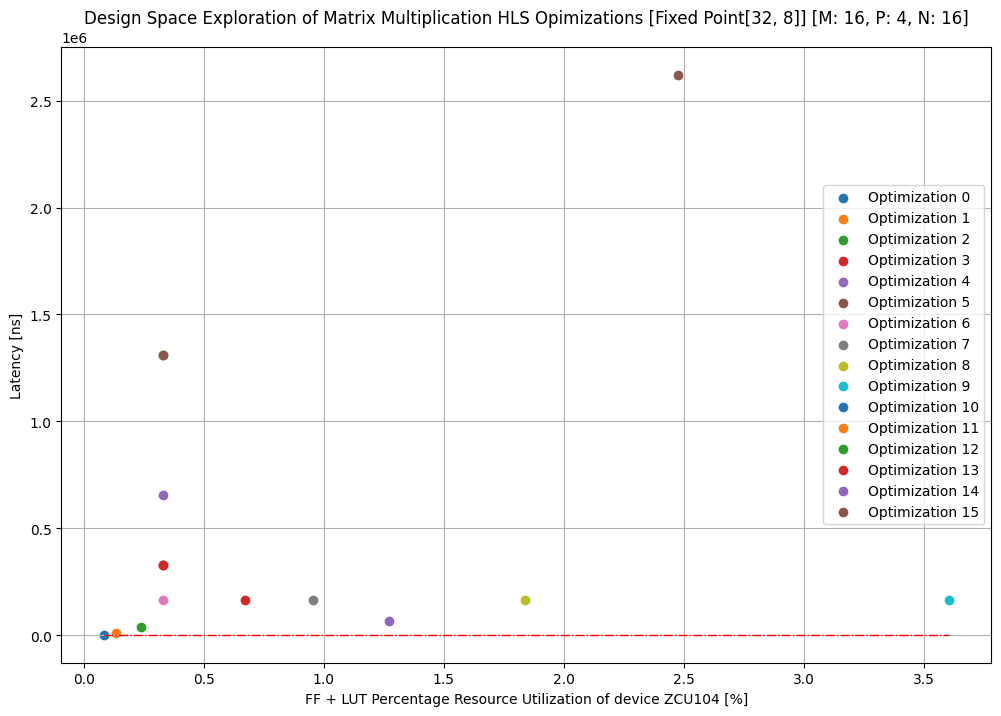

In [96]:
sorted_idx = np.argsort(dfResults["(FF + LUT)%"])
x_sorted = dfResults["(FF + LUT)%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["(FF + LUT)%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("FF + LUT Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1523632350.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["LUT%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1523632350.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1523632350.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x =

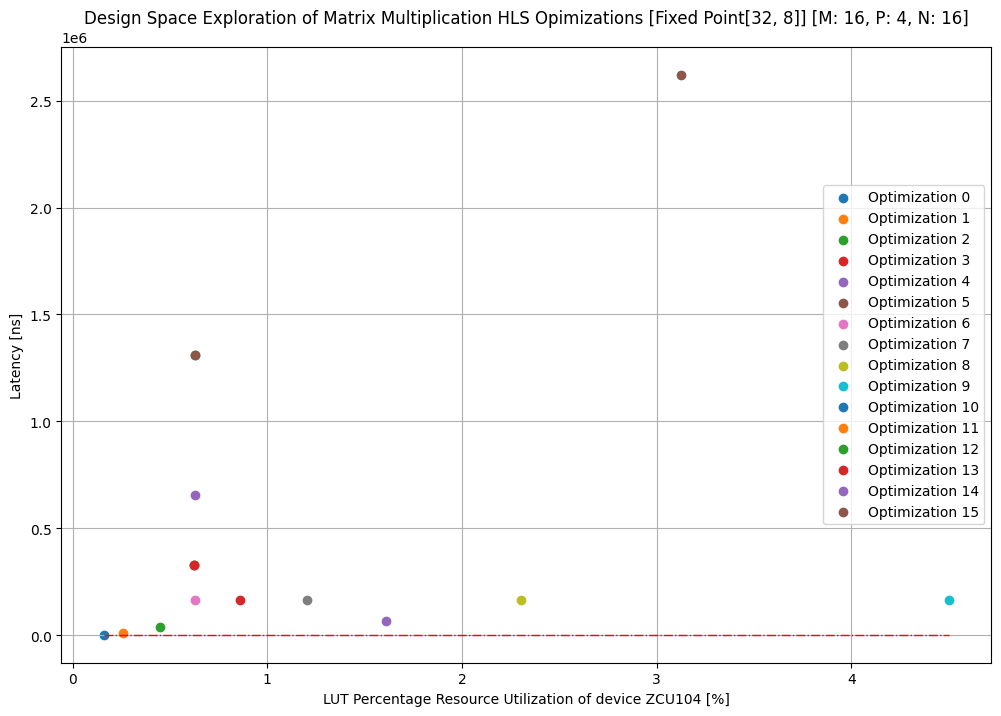

In [97]:
sorted_idx = np.argsort(dfResults["LUT%"])
x_sorted = dfResults["LUT%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["LUT%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("LUT Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1797660723.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["FF%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1797660723.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1797660723.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x = 

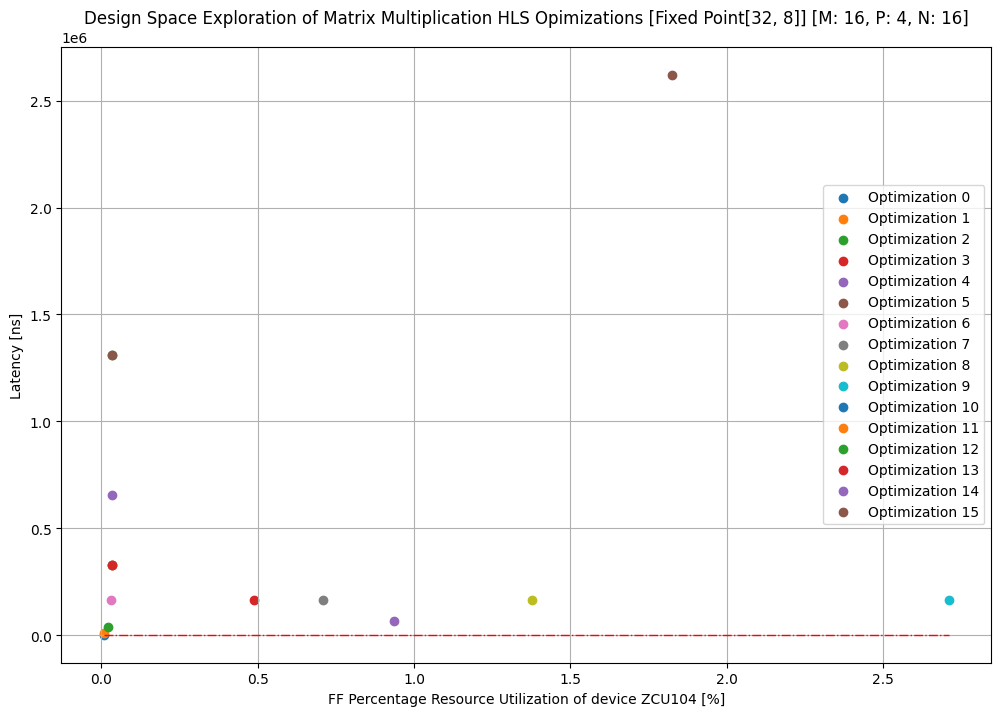

In [98]:
sorted_idx = np.argsort(dfResults["FF%"])
x_sorted = dfResults["FF%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["FF%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("FF Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_11688\415851927.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["DSP%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\415851927.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\415851927.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x = [x

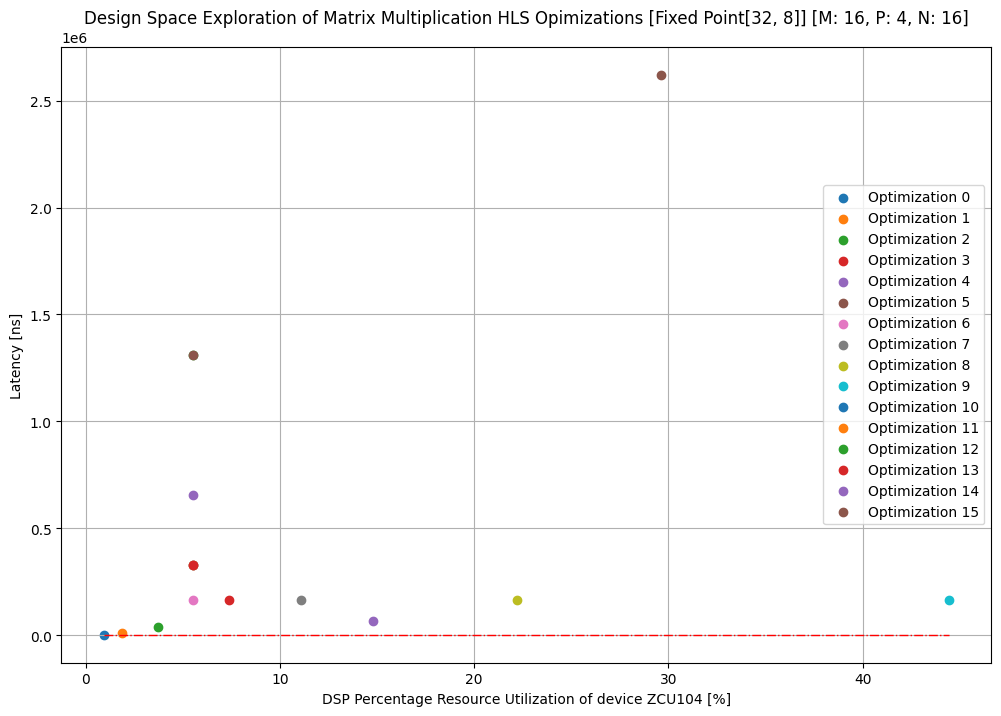

In [99]:
sorted_idx = np.argsort(dfResults["DSP%"])
x_sorted = dfResults["DSP%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["DSP%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("DSP Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_11688\3419153151.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["(FF + LUT)%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\3419153151.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\3419153151.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lo

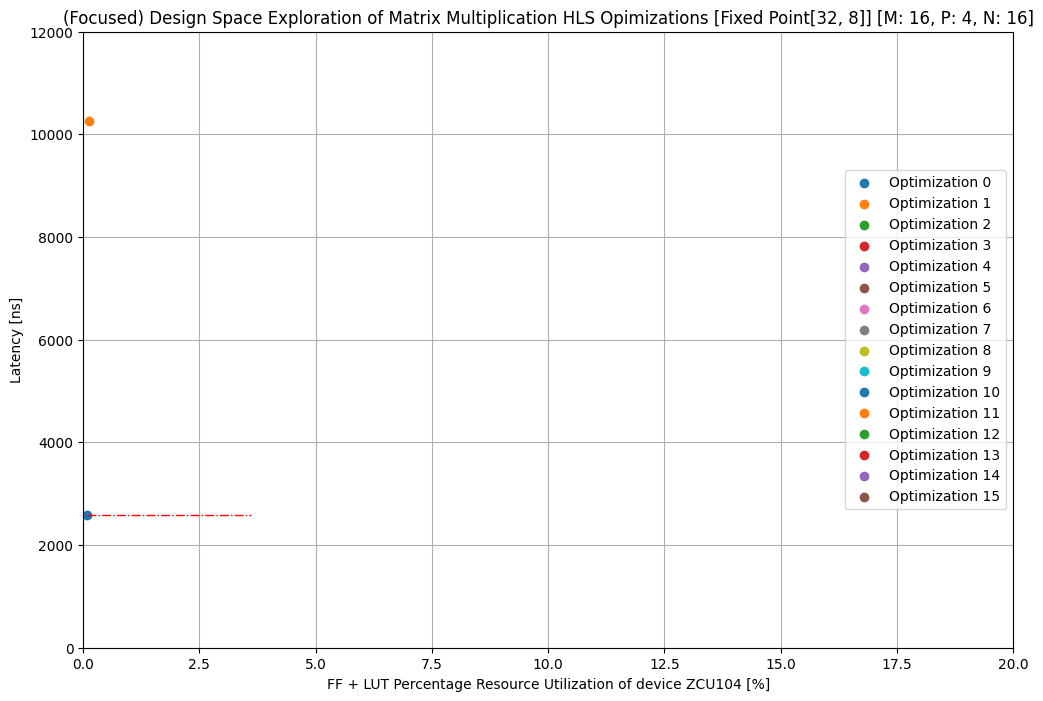

In [100]:
sorted_idx = np.argsort(dfResults["(FF + LUT)%"])
x_sorted = dfResults["(FF + LUT)%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["(FF + LUT)%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("FF + LUT Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("(Focused) Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
ax.set_ylim([0, 12000])
ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_11688\2009374920.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["DSP%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\2009374920.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\2009374920.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x =

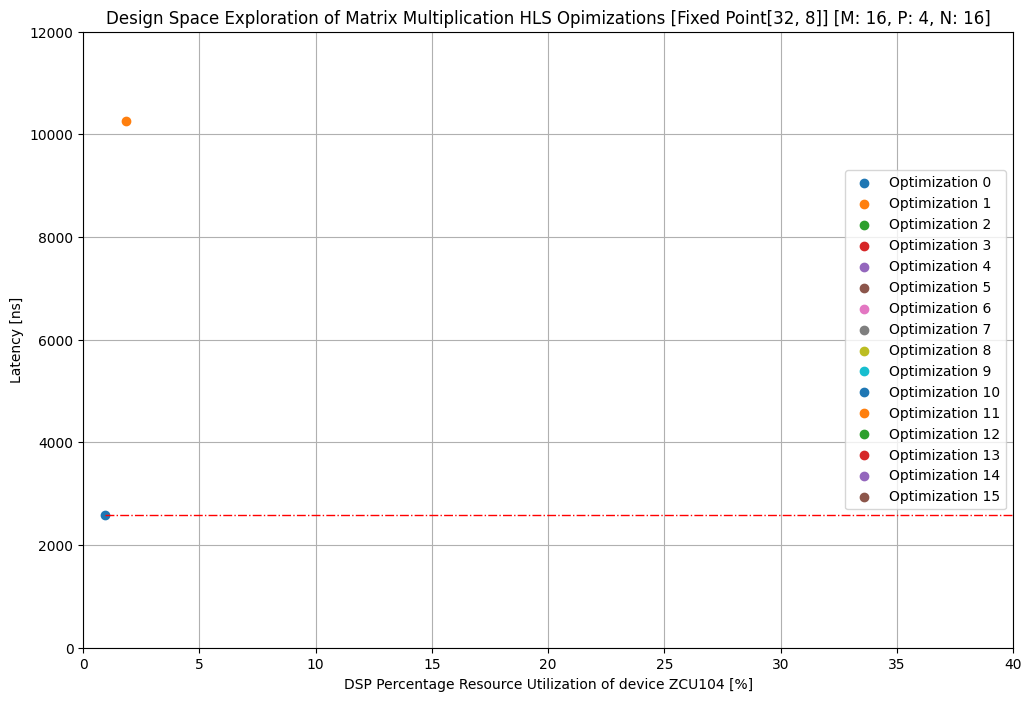

In [101]:
sorted_idx = np.argsort(dfResults["DSP%"])
x_sorted = dfResults["DSP%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["DSP%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("DSP Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])

ax.set_ylim([0, 12000])
ax.set_xlim([0, 40])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

In [102]:
reports.append(HLSReport(
    reportName="Report18",
    latency_ns=49610,
    bram=0,
    dsp=0,
    ff=421992,
    lut=786517,
    uram=0,
    taskSpecificInfo={
        "M": 197,
        "P": 32,
        "N": 197
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=4
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=4
            )),
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=4)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

In [103]:
dfResults.columns

Index(['M', 'P', 'N', 'Latency_ns', 'BRAM', 'DSP', 'FF', 'LUT', 'URAM',
       'BRAM%', 'DSP%', 'FF%', 'LUT%', 'URAM%', '(FF + LUT)%'],
      dtype='object')

C:\Users\lions\AppData\Local\Temp\ipykernel_11688\943766213.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["M"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\943766213.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\943766213.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x = [x_so

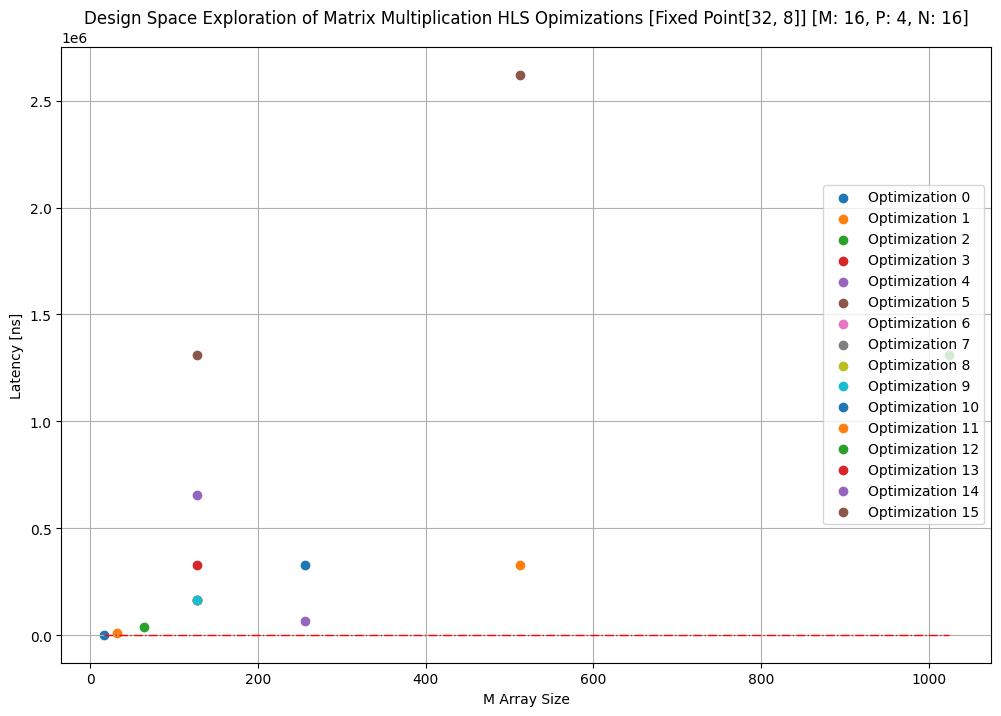

In [104]:
sorted_idx = np.argsort(dfResults["M"])
x_sorted = dfResults["M"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["M"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("M Array Size")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])


#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_11688\2052957653.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["N"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\2052957653.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\2052957653.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x = [x

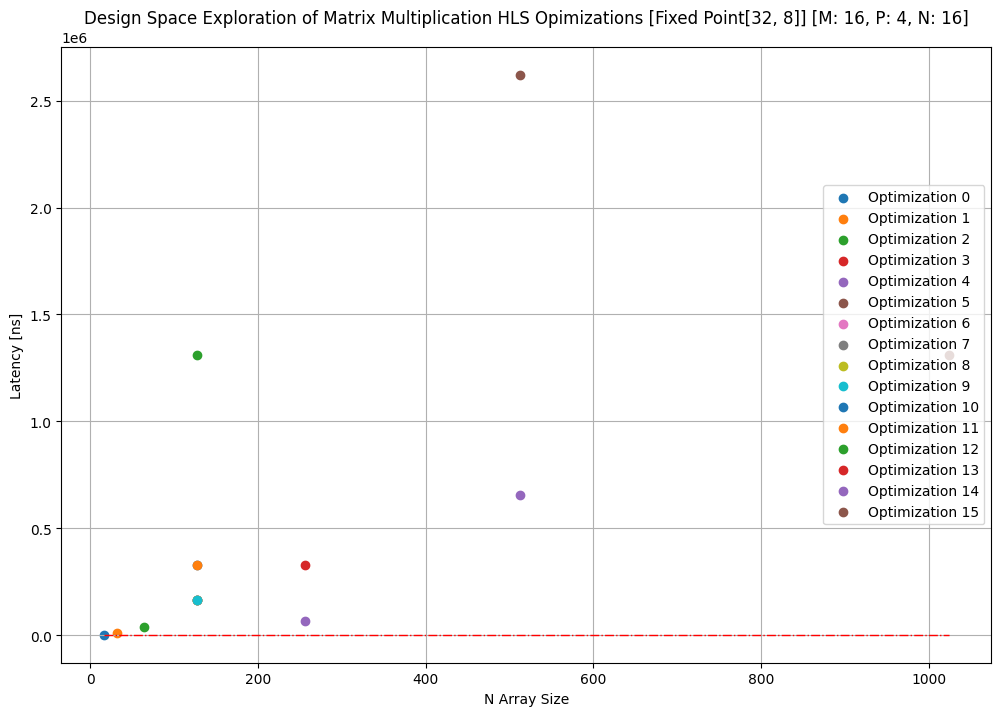

In [105]:
sorted_idx = np.argsort(dfResults["N"])
x_sorted = dfResults["N"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["N"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("N Array Size")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])


#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_11688\671514883.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["P"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\671514883.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\671514883.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x = [x_so

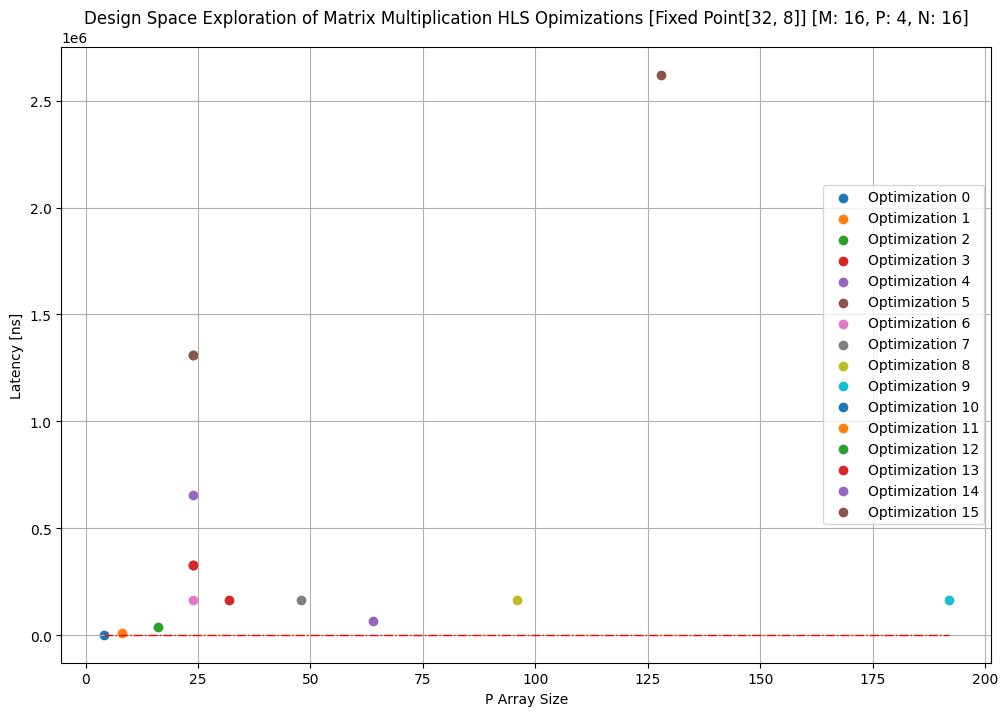

In [106]:
sorted_idx = np.argsort(dfResults["P"])
x_sorted = dfResults["P"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["P"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("P Array Size")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])


#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1364867570.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["M"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1364867570.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["LUT%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_11688\1364867570.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x = [x_sorte

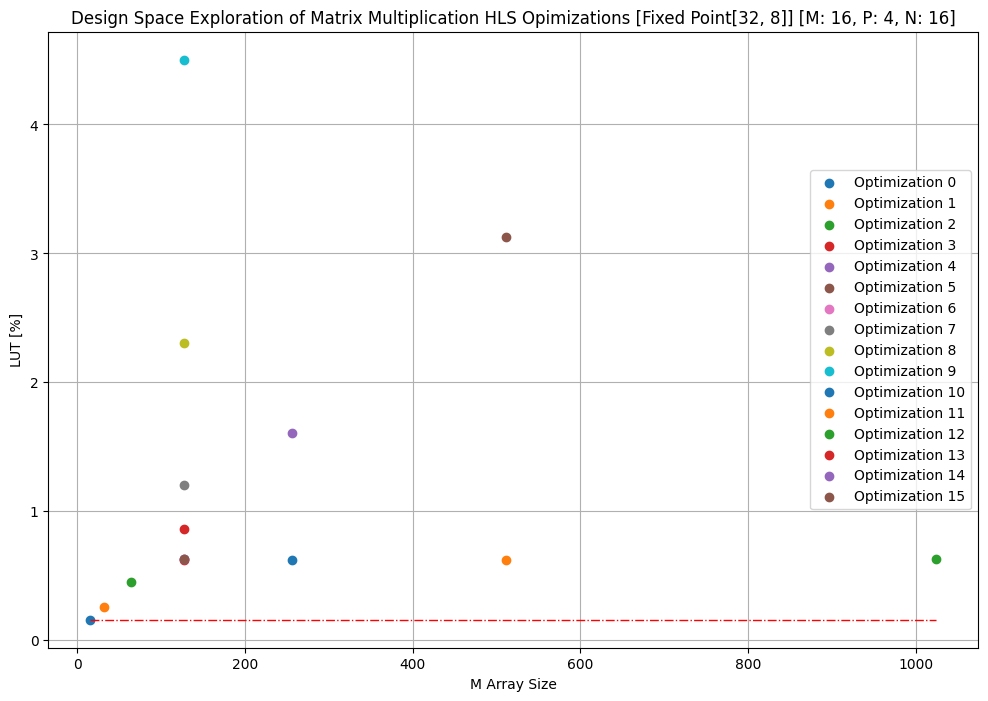

In [107]:
sorted_idx = np.argsort(dfResults["M"])
x_sorted = dfResults["M"][sorted_idx]
y_sorted = dfResults["LUT%"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["M"][i], dfResults["LUT%"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("M Array Size")
ax.set_ylabel("LUT [%]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])


#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

In [113]:
dfResults

,M,P,N,Latency_ns,BRAM,DSP,FF,LUT,URAM,BRAM%,DSP%,FF%,LUT%,URAM%,(FF + LUT)%
Optimization 0,16,4,16,2590,0,16,33,366,0,0.0,0.925926,0.007161,0.158854,0.0,0.083008
Optimization 1,32,8,32,10270,0,32,39,599,0,0.0,1.851852,0.008464,0.259983,0.0,0.134223
Optimization 2,64,16,64,41000,0,64,105,1040,0,0.0,3.703704,0.022786,0.451389,0.0,0.237088
Optimization 3,128,32,128,164000,0,128,2249,1983,0,0.0,7.407407,0.488064,0.860677,0.0,0.674371
Optimization 4,256,64,256,65500,0,256,4306,3709,0,0.0,14.814815,0.934462,1.609809,0.0,1.272135
Optimization 5,512,128,512,2621000,0,512,8410,7201,0,0.0,29.629630,1.825087,3.125434,0.0,2.475260
Optimization 6,128,24,128,164000,0,96,147,1453,0,0.0,5.555556,0.031901,0.630642,0.0,0.331272
Optimization 7,128,48,128,164000,0,192,3273,2773,0,0.0,11.111111,0.710286,1.203559,0.0,0.956923
Optimization 8,128,96,128,164000,0,384,6345,5311,0,0.0,22.222222,1.376953,2.305122,0.0,1.841037
Optimization 9,128,192,128,164000,0,768,12489,10373,0,0.0,44.444444,2.710286,4.502170,0.0,3.606228


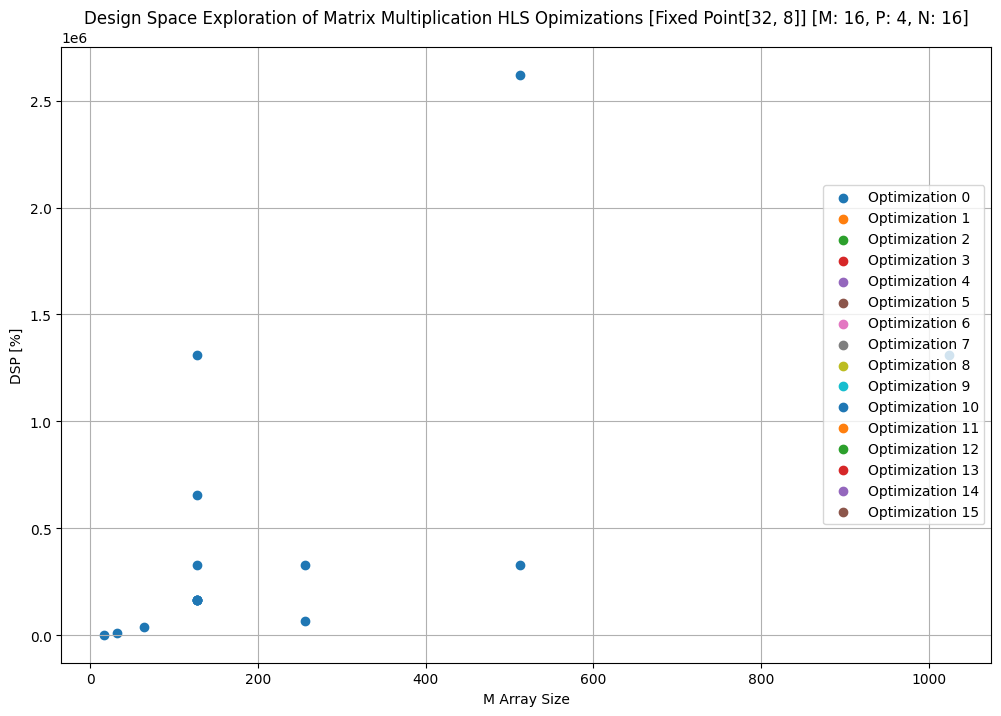

In [112]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)
ax.scatter(dfResults["M"], dfResults["Latency_ns"])
ax.legend(handles=handles, loc="center right")
ax.set_xlabel("M Array Size")
ax.set_ylabel("DSP [%]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])


#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)